<div style="text-align: right">   </div>


Introduction to Deep Learning (2024) &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;| &nbsp;
-------|-------------------
**Assignment 2 - Sequence processing using RNNs** | <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b0/UniversiteitLeidenLogo.svg/1280px-UniversiteitLeidenLogo.svg.png" width="300">



# Introduction


The goal of this assignment is to learn how to use encoder-decoder recurrent neural networks (RNNs). Specifically we will be dealing with a sequence to sequence problem and try to build recurrent models that can learn the principles behind simple arithmetic operations (**integer addition, subtraction and multiplication.**).

<img src="https://i.ibb.co/5Ky5pbk/Screenshot-2023-11-10-at-07-51-21.png" alt="Screenshot-2023-11-10-at-07-51-21" border="0" width="500"></a>

In this assignment you will be working with three different kinds of models, based on input/output data modalities:
1. **Text-to-text**: given a text query containing two integers and an operand between them (+ or -) the model's output should be a sequence of integers that match the actual arithmetic result of this operation
2. **Image-to-text**: same as above, except the query is specified as a sequence of images containing individual digits and an operand.
3. **Text-to-image**: the query is specified in text format as in the text-to-text model, however the model's output should be a sequence of images corresponding to the correct result.


### Description**
Let us suppose that we want to develop a neural network that learns how to add or subtract
two integers that are at most two digits long. For example, given input strings of 5 characters: ‘81+24’ or
’41-89’ that consist of 2 two-digit long integers and an operand between them, the network should return a
sequence of 3 characters: ‘105 ’ or ’-48 ’ that represent the result of their respective queries. Additionally,
we want to build a model that generalizes well - if the network can extract the underlying principles behind
the ’+’ and ’-’ operands and associated operations, it should not need too many training examples to generate
valid answers to unseen queries. To represent such queries we need 13 unique characters: 10 for digits (0-9),
2 for the ’+’ and ’-’ operands and one for whitespaces ’ ’ used as padding.
The example above describes a text-to-text sequence mapping scenario. However, we can also use different
modalities of data to represent our queries or answers. For that purpose, the MNIST handwritten digit
dataset is going to be used again, however in a slightly different format. The functions below will be used to create our datasets.

---

*To work on this notebook you should create a copy of it.*


# Function definitions for creating the datasets

First we need to create our datasets that are going to be used for training our models.

In order to create image queries of simple arithmetic operations such as '15+13' or '42-10' we need to create images of '+' and '-' signs using ***open-cv*** library. We will use these operand signs together with the MNIST dataset to represent the digits.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
import random
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, RNN, LSTM, Flatten, TimeDistributed, LSTMCell
from tensorflow.keras.layers import RepeatVector, Conv2D, SimpleRNN, GRU, Reshape, ConvLSTM2D, Conv2DTranspose

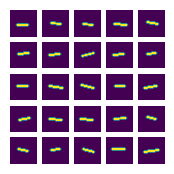

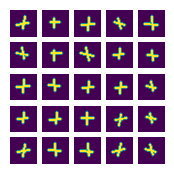

In [2]:
from scipy.ndimage import rotate


# Create plus/minus operand signs
def generate_images(number_of_images=50, sign='-'):
    blank_images = np.zeros([number_of_images, 28, 28])  # Dimensionality matches the size of MNIST images (28x28)
    x = np.random.randint(12, 16, (number_of_images, 2)) # Randomized x coordinates
    y1 = np.random.randint(6, 10, number_of_images)       # Randomized y coordinates
    y2 = np.random.randint(18, 22, number_of_images)     # -||-

    for i in range(number_of_images): # Generate n different images
        cv2.line(blank_images[i], (y1[i], x[i,0]), (y2[i], x[i, 1]), (255,0,0), 2, cv2.LINE_AA)     # Draw lines with randomized coordinates
        if sign == '+':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA) # Draw lines with randomized coordinates
        if sign == '*':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)
            # Rotate 45 degrees
            blank_images[i] = rotate(blank_images[i], -50, reshape=False)
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)
            blank_images[i] = rotate(blank_images[i], -50, reshape=False)
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)

    return blank_images

def show_generated(images, n=5):
    plt.figure(figsize=(2, 2))
    for i in range(n**2):
        plt.subplot(n, n, i+1)
        plt.axis('off')
        plt.imshow(images[i])
    plt.show()

show_generated(generate_images())
show_generated(generate_images(sign='+'))

In [3]:
def create_data(highest_integer, num_addends=2, operands=['+', '-']):
    """
    Creates the following data for all pairs of integers up to [1:highest integer][+/-][1:highest_integer]:

    @return:
    X_text: '51+21' -> text query of an arithmetic operation (5)
    X_img : Stack of MNIST images corresponding to the query (5 x 28 x 28) -> sequence of 5 images of size 28x28
    y_text: '72' -> answer of the arithmetic text query
    y_img :  Stack of MNIST images corresponding to the answer (3 x 28 x 28)

    Images for digits are picked randomly from the whole MNIST dataset.
    """

    num_indices = [np.where(MNIST_labels==x) for x in range(10)]
    num_data = [MNIST_data[inds] for inds in num_indices]
    image_mapping = dict(zip(unique_characters[:10], num_data))
    image_mapping['-'] = generate_images()
    image_mapping['+'] = generate_images(sign='+')
    image_mapping['*'] = generate_images(sign='*')
    image_mapping[' '] = np.zeros([1, 28, 28])

    X_text, X_img, y_text, y_img = [], [], [], []

    for i in range(highest_integer + 1):      # First addend
        for j in range(highest_integer + 1):  # Second addend
            for sign in operands: # Create all possible combinations of operands
                query_string = to_padded_chars(str(i) + sign + str(j), max_len=max_query_length, pad_right=True)
                query_image = []
                for n, char in enumerate(query_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    query_image.append(image_set[index].squeeze())

                result = eval(query_string)
                result_string = to_padded_chars(result, max_len=max_answer_length, pad_right=True)
                result_image = []
                for n, char in enumerate(result_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    result_image.append(image_set[index].squeeze())

                X_text.append(query_string)
                X_img.append(np.stack(query_image))
                y_text.append(result_string)
                y_img.append(np.stack(result_image))

    return np.stack(X_text), np.stack(X_img)/255., np.stack(y_text), np.stack(y_img)/255.

def to_padded_chars(integer, max_len=3, pad_right=False):
    """
    Returns a string of len()=max_len, containing the integer padded with ' ' on either right or left side
    """
    length = len(str(integer))
    padding = (max_len - length) * ' '
    if pad_right:
        return str(integer) + padding
    else:
        return padding + str(integer)


# Creating our data

The dataset consists of 20000 samples that (additions and subtractions between all 2-digit integers) and they have two kinds of inputs and label modalities:

  **X_text**: strings containing queries of length 5: ['  1+1  ', '11-18', ...]

  **X_image**: a stack of images representing a single query, dimensions: [5, 28, 28]

  **y_text**: strings containing answers of length 3: ['  2', '156']

  **y_image**: a stack of images that represents the answer to a query, dimensions: [3, 28, 28]

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(20000,) (20000, 5, 28, 28) (20000,) (20000, 3, 28, 28)
Query #2137

X_text: "10-68" = y_text: "-58"


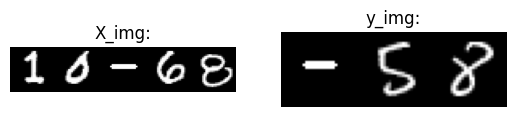

Query #1335

X_text: "6-67 " = y_text: "-61"


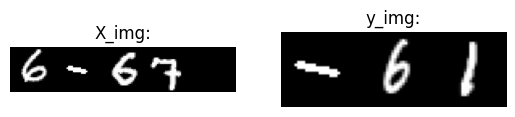

Query #5126

X_text: "25+63" = y_text: "88 "


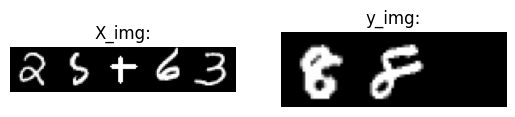

Query #3687

X_text: "18-43" = y_text: "-25"


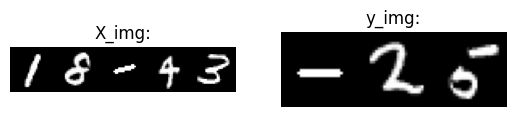

Query #3601

X_text: "18-0 " = y_text: "18 "


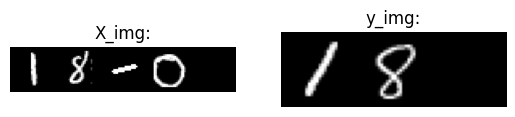

Query #4883

X_text: "24-41" = y_text: "-17"


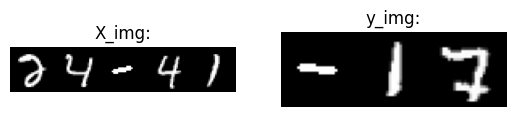

Query #3432

X_text: "17+16" = y_text: "33 "


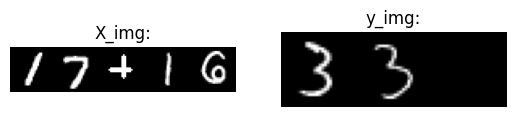

Query #948

X_text: "4+74 " = y_text: "78 "


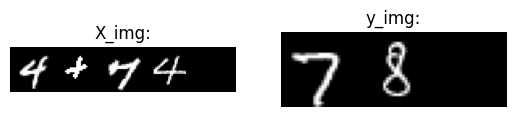

Query #5101

X_text: "25-50" = y_text: "-25"


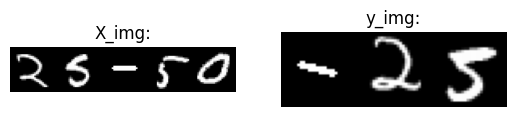

Query #3496

X_text: "17+48" = y_text: "65 "


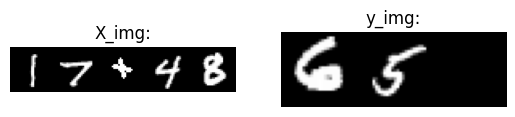

In [4]:
# Illustrate the generated query/answer pairs

unique_characters = '0123456789+- '       # All unique characters that are used in the queries (13 in total: digits 0-9, 2 operands [+, -], and a space character ' '.)
highest_integer = 99                      # Highest value of integers contained in the queries

max_int_length = len(str(highest_integer))# Maximum number of characters in an integer
max_query_length = max_int_length * 2 + 1 # Maximum length of the query string (consists of two integers and an operand [e.g. '22+10'])
max_answer_length = 3    # Maximum length of the answer string (the longest resulting query string is ' 1-99'='-98')

# Create the data (might take around a minute)
(MNIST_data, MNIST_labels), _ = tf.keras.datasets.mnist.load_data()
X_text, X_img, y_text, y_img = create_data(highest_integer)
print(X_text.shape, X_img.shape, y_text.shape, y_img.shape)


## Display the samples that were created
def display_sample(n):
    labels = ['X_img:', 'y_img:']
    for i, data in enumerate([X_img, y_img]):
        plt.subplot(1,2,i+1)
        # plt.set_figheight(15)
        plt.axis('off')
        plt.title(labels[i])
        plt.imshow(np.hstack(data[n]), cmap='gray')
    print('='*50, f'\nQuery #{n}\n\nX_text: "{X_text[n]}" = y_text: "{y_text[n]}"')
    plt.show()

for _ in range(10):
    display_sample(np.random.randint(0, 10000, 1)[0])

## Helper functions

The functions below will help with input/output of the data.

In [5]:
# One-hot encoding/decoding the text queries/answers so that they can be processed using RNNs
# You should use these functions to convert your strings and read out the output of your networks

def encode_labels(labels, max_len=3):
  n = len(labels)
  length = len(labels[0])
  char_map = dict(zip(unique_characters, range(len(unique_characters))))
  one_hot = np.zeros([n, length, len(unique_characters)])
  for i, label in enumerate(labels):
      m = np.zeros([length, len(unique_characters)])
      for j, char in enumerate(label):
          m[j, char_map[char]] = 1
      one_hot[i] = m

  return one_hot


def decode_labels(labels):
    pred = np.argmax(labels, axis=1)
    predicted = ''.join([unique_characters[i] for i in pred])

    return predicted

X_text_onehot = encode_labels(X_text)
y_text_onehot = encode_labels(y_text)

print(X_text_onehot.shape, y_text_onehot.shape)

(20000, 5, 13) (20000, 3, 13)


---
---

## I. Text-to-text RNN model

The following code showcases how Recurrent Neural Networks (RNNs) are built using Keras. Several new layers are going to be used:

1. LSTM
2. TimeDistributed
3. RepeatVector

The code cell below explains each of these new components.

<img src="https://i.ibb.co/NY7FFTc/Screenshot-2023-11-10-at-09-27-25.png" alt="Screenshot-2023-11-10-at-09-27-25" border="0" width="500"></a>


In [6]:
def build_text2text_model(add_more_LSTM=False):

    # We start by initializing a sequential model
    text2text = tf.keras.Sequential()

    # "Encode" the input sequence using an RNN, producing an output of size 256.
    # In this case the size of our input vectors is [5, 13] as we have queries of length 5 and 13 unique characters. Each of these 5 elements in the query will be fed to the network one by one,
    # as shown in the image above (except with 5 elements).
    # Hint: In other applications, where your input sequences have a variable length (e.g. sentences), you would use input_shape=(None, unique_characters).
    if not add_more_LSTM:
        text2text.add(LSTM(256, input_shape=(None, len(unique_characters))))
    else:
        text2text.add(LSTM(256, input_shape=(None, len(unique_characters)),return_sequences=True))
        text2text.add(LSTM(256))

    # As the decoder RNN's input, repeatedly provide with the last output of RNN for each time step. Repeat 3 times as that's the maximum length of the output (e.g. '  1-99' = '-98')
    # when using 2-digit integers in queries. In other words, the RNN will always produce 3 characters as its output.
    text2text.add(RepeatVector(max_answer_length))

    # By setting return_sequences to True, return not only the last output but all the outputs so far in the form of (num_samples, timesteps, output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    text2text.add(LSTM(256, return_sequences=True))

    # Apply a dense layer to the every temporal slice of an input. For each of step of the output sequence, decide which character should be chosen.
    text2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))

    # Next we compile the model using categorical crossentropy as our loss function.
    text2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    text2text.summary()

    return text2text

In [7]:
## Your code (look at the assignment description for your tasks for text-to-text model):
def train_text_2_text_model(x_train,x_test,y_train,y_test,batch_size=32, epochs=50,patience=15):

    text2text_model = build_text2text_model()
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=patience,restore_best_weights=True)

    # Train the model with Early Stopping
    history = text2text_model.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_test,y_test),
        callbacks=[early_stopping_cb]
    )

    # Plot the training and validation loss
    plt.plot(history.history['loss'], label='Training Loss')
    plt.legend()
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    return text2text_model

In [8]:
# Helper function to check if borrowing is required
def requires_borrowing(query):
    if "-" not in query:
        return False  # Not subtraction
    minuend, subtrahend = query.split("-")
    minuend, subtrahend = minuend.strip(), subtrahend.strip()
    for min_digit, sub_digit in zip(reversed(minuend), reversed(subtrahend)):
        if int(min_digit) < int(sub_digit):
            return True  # Borrowing required
    return False

# Helper function to check if carrying is required
def requires_carry(query):
    if "+" not in query:
        return False  # Not addition
    addend1, addend2 = query.split("+")
    addend1, addend2 = addend1.strip(), addend2.strip()
    for add_digit1, add_digit2 in zip(reversed(addend1), reversed(addend2)):
        if int(add_digit1) + int(add_digit2) > 9:
            return True  # Carrying required
    return False

def error_analysis(x_test,y_pre):
    misclassified = []
    total_characters = 0
    correct_characters = 0

    plus_errors = 0
    minus_errors = 0
    plus_total = 0
    minus_total = 0

    borrowing_cases = 0
    borrowing_errors = 0
    carry_cases = 0
    carry_errors = 0

    for i in range(y_pre.shape[0]):
        predict = decode_labels(y_pre[i])
        true = decode_labels(y_test[i])

        total_characters += len(true)
        correct_characters += sum(p == t for p, t in zip(predict, true))

        query = decode_labels(x_test[i])

        if "+" in query:
            plus_total+=1
            if predict != true:
                 plus_errors+=1

        if "-" in query:
            minus_total+=1
            if predict != true:
                 minus_errors+=1

        if requires_carry(query):
            carry_cases += 1
            if predict != true:
                carry_errors+=1

        if requires_borrowing(query):
            borrowing_cases += 1
            if predict != true:
                borrowing_errors+=1

        if predict != true:
            misclassified.append((i, predict, true,query))


    print(f"Number of misclassification: {len(misclassified)}, error_ratio:{len(misclassified)/(y_pre.shape[0])*100}%")
    print(f"Character-level accuracy: {correct_characters / total_characters:.2%}")

    # Calculate error rates
    plus_error_rate = (plus_errors / plus_total) * 100 if plus_total > 0 else 0
    minus_error_rate = (minus_errors / minus_total) * 100 if minus_total > 0 else 0

    borrowing_error_rate = (borrowing_errors / borrowing_cases) * 100 if borrowing_cases > 0 else 0
    carry_error_rate = (carry_errors / carry_cases) * 100 if carry_cases > 0 else 0
    borrow_carry_ratio = (carry_errors + borrowing_errors)/len(misclassified) * 100 if len(misclassified) > 0 else 0

    # Display results
    print(f"Addition (+) Error Rate: {plus_error_rate:.2f}% ({plus_errors}/{plus_total})")
    print(f"Subtraction (-) Error Rate: {minus_error_rate:.2f}% ({minus_errors}/{minus_total})")
    print(f"Borrowing (->) Error Rate: {borrowing_error_rate:.2f}% ({borrowing_errors}/{borrowing_cases})")
    print(f"Carrying (<-) Error Rate: {carry_error_rate:.2f}% ({carry_errors}/{carry_cases})")
    print(f"Borrow_Carry_Error/Total_Error: {borrow_carry_ratio:.2f} % ({carry_errors + borrowing_errors}/{len(misclassified)})")

    # Visualize
    for idx, pred, true,query in misclassified[:10]:
        print(f"Sample #{idx}")
        print(f"Query: {query}")
        print(f"Predicted: {pred}")
        print(f"True: {true}")
        print("=" * 50)


### Train-Test(50-50)

(10000, 5, 13) (10000, 5, 13) (10000, 3, 13) (10000, 3, 13)


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 256)            │       276,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 3, 13)          │         3,341 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 805,133 (3.07 MB)

 Trainable params: 805,133 (3.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.3147 - loss: 2.1058 - val_accuracy: 0.4244 - val_loss: 1.6229
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4422 - loss: 1.5501 - val_accuracy: 0.5121 - val_loss: 1.3572
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5170 - loss: 1.3303 - val_accuracy: 0.5472 - val_loss: 1.2404
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5540 - loss: 1.2340 - val_accuracy: 0.5571 - val_loss: 1.1902
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5853 - loss: 1.1486 - val_accuracy: 0.5923 - val_loss: 1.0984
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5967 - loss: 1.1000 - val_accuracy: 0.6072 - val_loss: 1.0565
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6100 - loss: 1.0528 - val_accuracy: 0.6240 - val_loss: 1.0174
Epoch 8/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6267 - loss: 1.0141 - val_accuracy: 0.

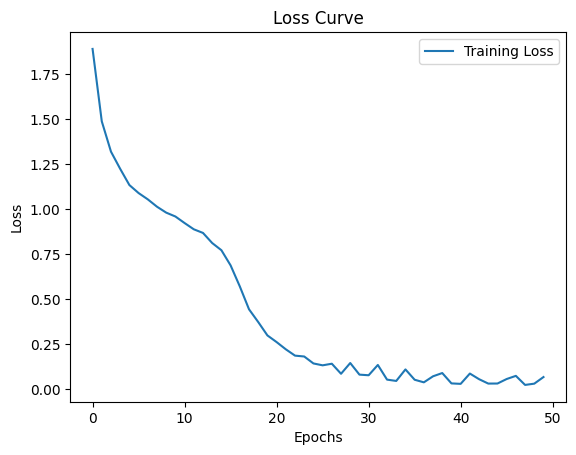

In [9]:
(x_train,x_test,y_train,y_test)= train_test_split(X_text_onehot,y_text_onehot,test_size=0.5)
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

text2text_model1 = train_text_2_text_model(x_train,x_test,y_train,y_test,32,50,15)

In [10]:
loss, accuracy = text2text_model1.evaluate(x_test,y_test)
y_pre = text2text_model1(x_test)
error_analysis(x_test,y_pre)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9909 - loss: 0.0328
Number of misclassification: 256, error_ratio:2.56%
Character-level accuracy: 99.11%
Addition (+) Error Rate: 1.70% (85/4993)
Subtraction (-) Error Rate: 3.42% (171/5007)
Borrowing (->) Error Rate: 2.80% (91/3255)
Carrying (<-) Error Rate: 0.86% (30/3472)
Borrow_Carry_Error/Total_Error: 47.27 % (121/256)
Sample #7
Query: 72-70
Predicted: 1  
True: 2  
Sample #63
Query: 1-61 
Predicted: -50
True: -60
Sample #75
Query: 91+91
Predicted: 183
True: 182
Sample #188
Query: 99+99
Predicted: 197
True: 198
Sample #267
Query: 0-6  
Predicted: -7 
True: -6 
Sample #397
Query: 80-78
Predicted: 1  
True: 2  
Sample #407
Query: 1-0  
Predicted: -  
True: 1  
Sample #432
Query: 3+7  
Predicted: 90 
True: 10 
Sample #442
Query: 9-3  
Predicted: 7  
True: 6  
Sample #448
Query: 8-0  
Predicted: 7  
True: 8  


### Train-Test(25-75)

(5000, 5, 13) (15000, 5, 13) (5000, 3, 13) (15000, 3, 13)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 256)            │       276,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_1 (RepeatVector)  │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 3, 13)          │         3,341 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 805,133 (3.07 MB)

 Trainable params: 805,133 (3.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.2735 - loss: 2.2427 - val_accuracy: 0.3912 - val_loss: 1.7910
Epoch 2/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3930 - loss: 1.7540 - val_accuracy: 0.4297 - val_loss: 1.6154
Epoch 3/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4350 - loss: 1.5689 - val_accuracy: 0.4597 - val_loss: 1.4846
Epoch 4/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4620 - loss: 1.4896 - val_accuracy: 0.4981 - val_loss: 1.3653
Epoch 5/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4997 - loss: 1.3778 - val_accuracy: 0.5243 - val_loss: 1.3234
Epoch 6/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5244 - loss: 1.2959 - val_accuracy: 0.4997 - val_loss: 1.3224
Epoch 7/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5428 - loss: 1.2694 - val_accuracy: 0.5184 - val_loss: 1.2865
Epoch 8/100
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5581 - loss: 1.2311 - 

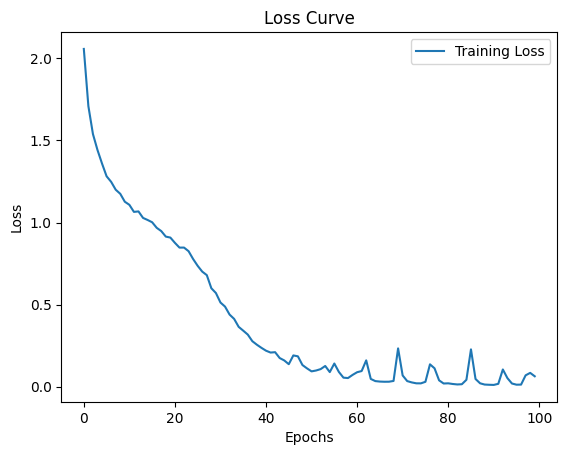

In [11]:
(x_train,x_test,y_train,y_test)= train_test_split(X_text_onehot,y_text_onehot,test_size=0.75)
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

text2text_model2 = train_text_2_text_model(x_train,x_test,y_train,y_test,32,100,15)

In [12]:
loss, accuracy = text2text_model2.evaluate(x_test,y_test)
# y_pre = text2text_model2(x_test)
# error_analysis(x_test,y_pre)

469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9765 - loss: 0.0778


### Train-Test(10-90)

(2000, 5, 13) (18000, 5, 13) (2000, 3, 13) (18000, 3, 13)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 256)            │       276,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_2 (RepeatVector)  │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 3, 13)          │         3,341 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 805,133 (3.07 MB)

 Trainable params: 805,133 (3.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.2239 - loss: 2.3936 - val_accuracy: 0.3273 - val_loss: 2.0807
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.3528 - loss: 1.9904 - val_accuracy: 0.3889 - val_loss: 1.8635
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.3903 - loss: 1.7896 - val_accuracy: 0.3945 - val_loss: 1.7747
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.4003 - loss: 1.7163 - val_accuracy: 0.4103 - val_loss: 1.6622
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.4142 - loss: 1.6584 - val_accuracy: 0.4234 - val_loss: 1.6081
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.4348 - loss: 1.5585 - val_accuracy: 0.4353 - val_loss: 1.5758
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.4534 - loss: 1.5149 - val_accuracy: 0.4381 - val_loss: 1.5571
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.4552 - loss: 1.4989 - val_accuracy: 0.

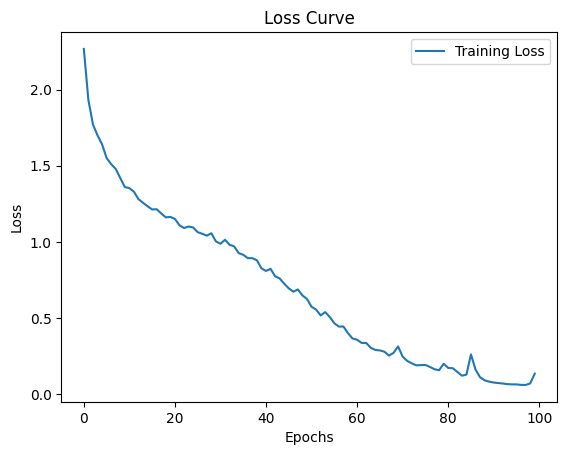

In [13]:
(x_train,x_test,y_train,y_test)= train_test_split(X_text_onehot,y_text_onehot,test_size=0.9)
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

text2text_model3 = train_text_2_text_model(x_train,x_test,y_train,y_test,32,100,15)

In [14]:
loss, accuracy = text2text_model3.evaluate(x_test,y_test)
# y_pre = text2text_model3(x_test)
# error_analysis(x_test,y_pre)

563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7737 - loss: 0.6921



---
---

## II. Image to text RNN Model

Hint: There are two ways of building the encoder for such a model - again by using the regular LSTM cells (with flattened images as input vectors) or recurrect convolutional layers [ConvLSTM2D](https://keras.io/api/layers/recurrent_layers/conv_lstm2d/).

The goal here is to use **X_img** as inputs and **y_text** as outputs.

In [15]:
from keras.layers import  MaxPooling2D

def build_img2text_model(add_more_LSTM=False):
    model=tf.keras.models.Sequential()
    model.add(TimeDistributed(Conv2D(16,kernel_size=(5,5), padding='same', activation='relu'), input_shape=(5,28,28,1)))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    model.add(TimeDistributed(Conv2D(32,kernel_size=(2,2), padding='same',activation='relu')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    model.add(TimeDistributed(Conv2D(64,kernel_size=(2,2), padding='same',activation='relu')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    model.add(TimeDistributed(Conv2D(128,kernel_size=(2,2), padding='same',activation='relu')))

    model.add(TimeDistributed(Flatten()))
    model.add(TimeDistributed(Dense(64,activation='linear')))
    if not add_more_LSTM:
        model.add(LSTM(256, return_sequences=False))
    else:
        model.add(LSTM(256,return_sequences=True))
        model.add(LSTM(256))

    model.add(RepeatVector(max_answer_length))

    model.add(LSTM(256, return_sequences=True))
    model.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

image2text_model = build_img2text_model()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_3              │ (None, 5, 28, 28, 16)  │           416 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 5, 14, 14, 16)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 5, 14, 14, 32)  │         2,080 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 5, 7, 7, 32)    │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 5, 7, 7, 64)    │         8,256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 5, 3, 3, 64)    │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 5, 3, 3, 128)   │        32,896 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, 5, 1152)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, 5, 64)          │        73,792 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 256)            │       328,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_3 (RepeatVector)  │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_12             │ (None, 3, 13)          │         3,341 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 974,797 (3.72 MB)

 Trainable params: 974,797 (3.72 MB)

 Non-trainable params: 0 (0.00 B)

(10000, 5, 28, 28, 1) (10000, 5, 28, 28, 1) (10000, 3, 13) (10000, 3, 13)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_13             │ (None, 5, 28, 28, 16)  │           416 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_14             │ (None, 5, 14, 14, 16)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_15             │ (None, 5, 14, 14, 32)  │         2,080 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_16             │ (None, 5, 7, 7, 32)    │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_17             │ (None, 5, 7, 7, 64)    │         8,256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_18             │ (None, 5, 3, 3, 64)    │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_19             │ (None, 5, 3, 3, 128)   │        32,896 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_20             │ (None, 5, 1152)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_21             │ (None, 5, 64)          │        73,792 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 256)            │       328,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_4 (RepeatVector)  │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_22             │ (None, 3, 13)          │         3,341 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 974,797 (3.72 MB)

 Trainable params: 974,797 (3.72 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.3198 - loss: 2.1164 - val_accuracy: 0.3936 - val_loss: 1.8679
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.3985 - loss: 1.8067 - val_accuracy: 0.4351 - val_loss: 1.6007
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.4517 - loss: 1.5365 - val_accuracy: 0.4774 - val_loss: 1.4453
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.4896 - loss: 1.4025 - val_accuracy: 0.4980 - val_loss: 1.3828
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.5325 - loss: 1.2819 - val_accuracy: 0.5558 - val_loss: 1.2209
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.5855 - loss: 1.1288 - val_accuracy: 0.6086 - val_loss: 1.0668
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.6580 - loss: 0.9282 - val_accuracy: 0.6890 - val_loss: 0.8725
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.7405 - loss: 0.7312 - val_acc

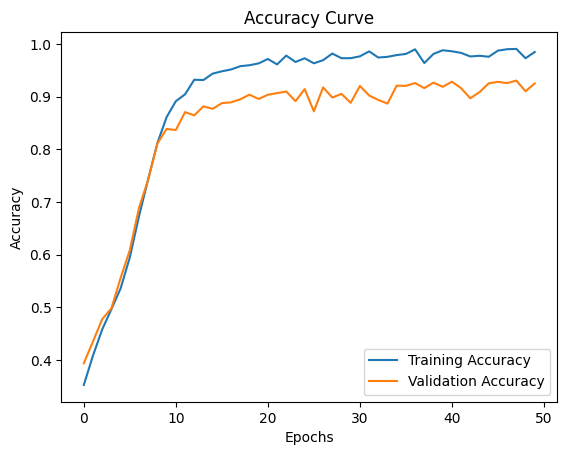

In [16]:
X_img = X_img.reshape((-1, 5, 28, 28, 1))
(x_img_train,x_img_test,y_text_train,y_text_test)= train_test_split(X_img,y_text_onehot,test_size=0.5)
print(x_img_train.shape,x_img_test.shape,y_text_train.shape,y_text_test.shape)

# Build the model
image2text_model = build_img2text_model()

# Train the model
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20,restore_best_weights=True)
history = image2text_model.fit(
    x_img_train,
    y_text_train,
    batch_size=16,
    epochs=50,
    validation_data=(x_img_test,y_text_test),
    callbacks=[early_stopping_cb]
)

# Plot training/test accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()


In [17]:
loss, accuracy = image2text_model.evaluate(x_img_test,y_text_test)

# Predict on a sample
sample_idx = 1  # Choose a sample
pre= image2text_model.predict(x_img_test[sample_idx:sample_idx+1])
predicted_text = decode_labels(pre[0])
true_text = decode_labels(y_text_test[sample_idx])
print(f"Predicted: {predicted_text}, True: {true_text}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9321 - loss: 0.3230
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step
Predicted: -24, True: -24


---
---

## III. Text to image RNN Model

Hint: to make this model work really well you could use deconvolutional layers in your decoder (you might need to look up ***Conv2DTranspose*** layer). However, regular vector-based decoder will work as well.

The goal here is to use **X_text** as inputs and **y_img** as outputs.

In [18]:
from tensorflow import keras
from functools import partial

# Model parameters
text_dim = 13  # Number of unique characters in queries (13)
max_query_len = max_query_length  # Length of input queries (5)
image_shape = (max_answer_length, 28, 28)  # Shape of output image sequence
lstm_units = 512

dense = partial(keras.layers.Dense,7 * 7 * 64,activation='relu')
reshape = partial(keras.layers.Reshape,(7, 7, 64))
convT1 = partial(keras.layers.Conv2DTranspose,32, (3, 3), activation='relu', strides=(2, 2), padding="same")
convT2 = partial(keras.layers.Conv2DTranspose,1, (3, 3), activation="sigmoid", strides=(2, 2), padding="same")
lstm1 = partial(keras.layers.LSTM,return_sequences=False)
lstm2 = partial(keras.layers.LSTM,return_sequences=True)
repeat_vector = partial(keras.layers.RepeatVector,image_shape[0])
inp = partial(keras.layers.Input,shape=(max_query_len, text_dim))

text_to_image_rnn = keras.models.Sequential([
inp(),
lstm1(lstm_units),
repeat_vector(),
lstm2(lstm_units),
TimeDistributed(dense()),
TimeDistributed(reshape()),
TimeDistributed(convT1()),
TimeDistributed(convT2())
])

# Instantiate and compile the model
text_to_image_rnn.compile(optimizer="adam", loss="mse", metrics=["accuracy"])
text_to_image_rnn.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 512)            │     1,077,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_5 (RepeatVector)  │ (None, 3, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 3, 512)         │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_23             │ (None, 3, 3136)        │     1,608,768 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_24             │ (None, 3, 7, 7, 64)    │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_25             │ (None, 3, 14, 14, 32)  │        18,464 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_26             │ (None, 3, 28, 28, 1)   │           289 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,803,969 (18.33 MB)

 Trainable params: 4,803,969 (18.33 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
X_text_onehot = encode_labels(X_text, max_len=max_query_length)

def decay_rate(epoch,lr):
  decay = 1e-1
  return lr/(1+decay*epoch)

early_stopping=keras.callbacks.EarlyStopping(monitor='val_loss',patience=10,mode='min',restore_best_weights=True)
decay_lr=keras.callbacks.LearningRateScheduler(decay_rate)

history = text_to_image_rnn.fit(
    X_text_onehot, y_img,
    validation_split=0.1,
    epochs=30,
    batch_size=16
)

Epoch 1/30
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.8624 - loss: 0.0755 - val_accuracy: 0.8585 - val_loss: 0.0549
Epoch 2/30
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.8663 - loss: 0.0543 - val_accuracy: 0.8558 - val_loss: 0.0579
Epoch 3/30
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.8658 - loss: 0.0490 - val_accuracy: 0.8532 - val_loss: 0.0591
Epoch 4/30
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.8647 - loss: 0.0473 - val_accuracy: 0.8532 - val_loss: 0.0557
Epoch 5/30
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.8637 - loss: 0.0468 - val_accuracy: 0.8522 - val_loss: 0.0546
Epoch 6/30
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.8633 - loss: 0.0465 - val_accuracy: 0.8507 - val_loss: 0.0535
Epoch 7/30
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.8638 - loss: 0.0461 - val_accuracy: 0.8533 - val_loss: 0.0628
Epoch 8/30
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.8636 - loss: 0.0458 -

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


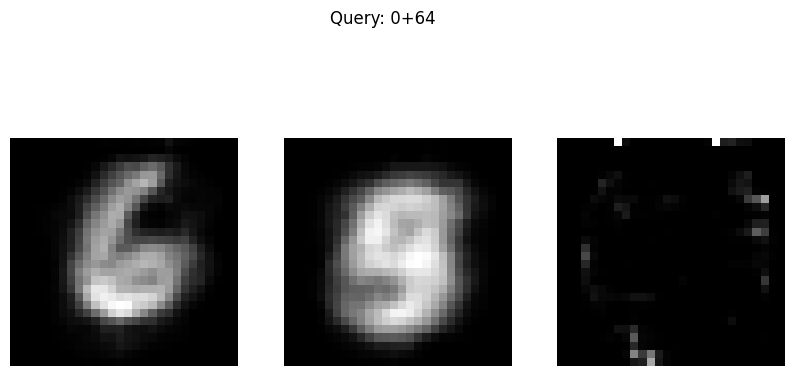

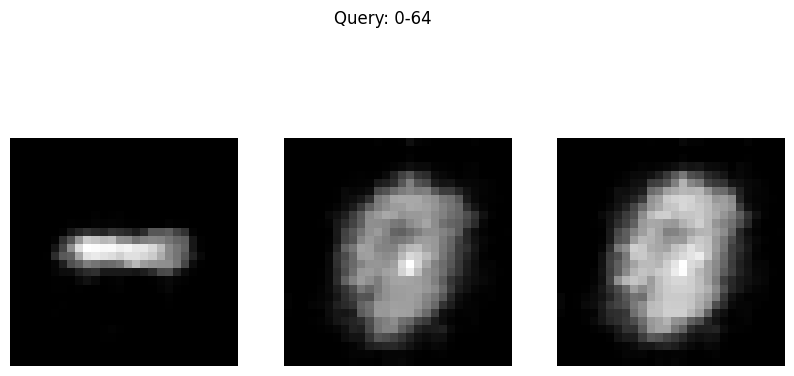

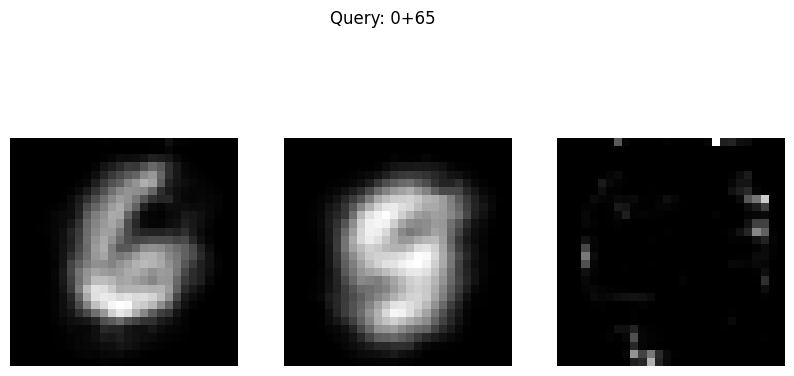

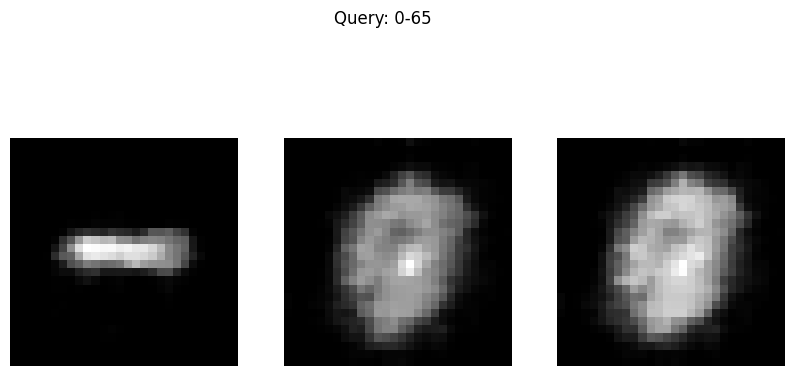

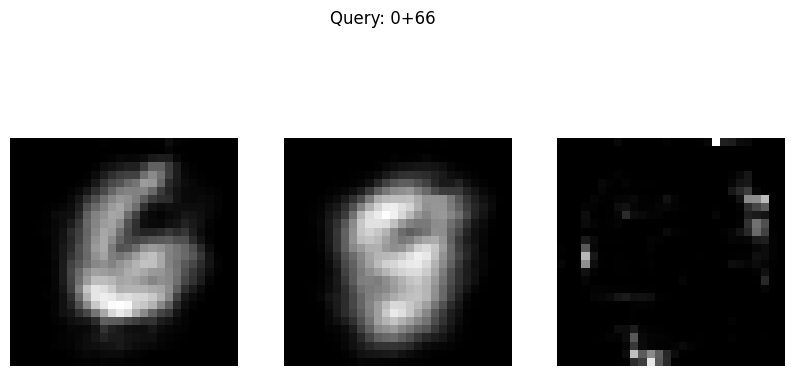

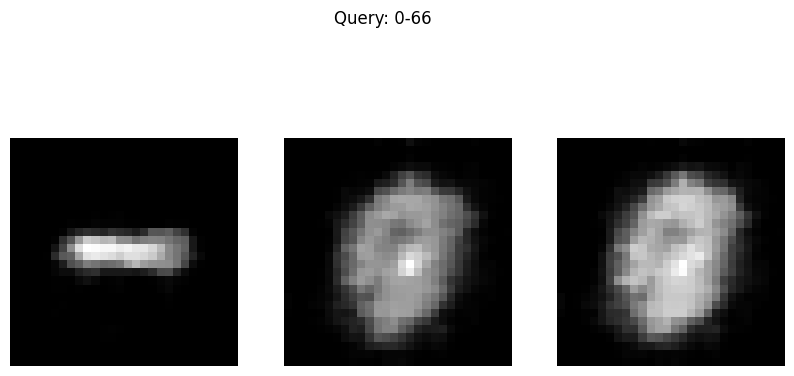

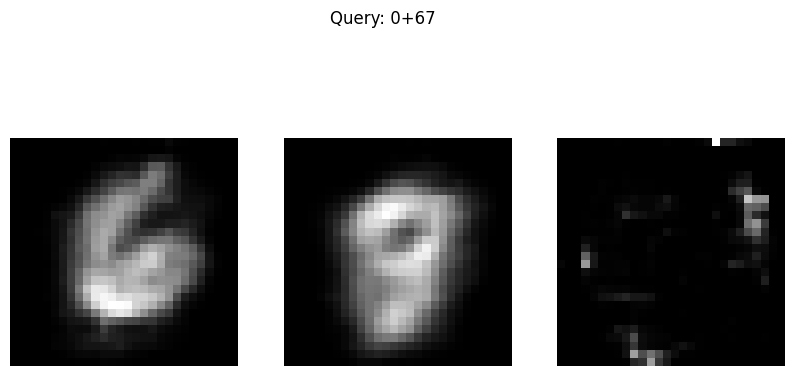

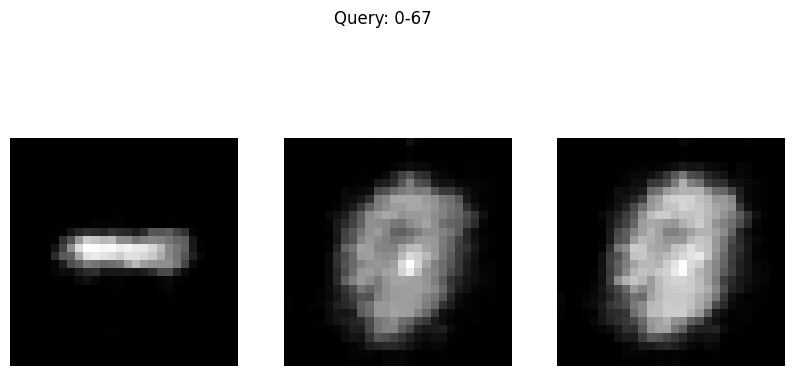

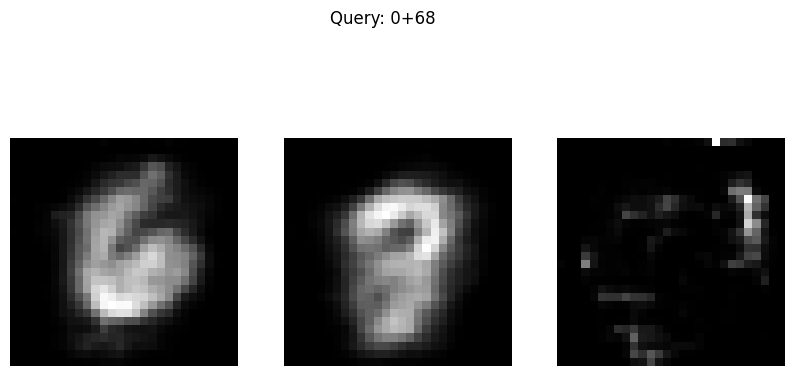

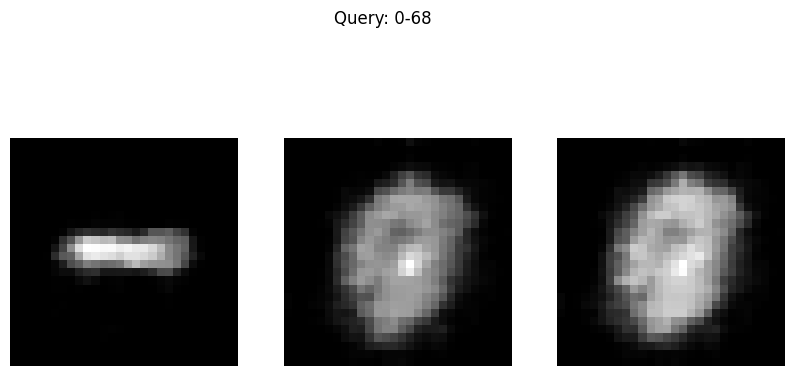

In [20]:
pred_img = text_to_image_rnn.predict(X_text_onehot[128:138])

for i in range(10):
    plt.figure(figsize=(10, 5))
    plt.suptitle(f"Query: {X_text[128+i]}")
    for t in range(max_answer_length):
        plt.subplot(1, max_answer_length, t + 1)
        plt.axis('off')
        plt.imshow(pred_img[i][t], cmap="gray")
    plt.show()

## IV. Adding additional LSTM layers

# Text-Text

In [21]:
## Your code (look at the assignment description for your tasks for text-to-text model):
def train_text_2_text_model(x_train,x_test,y_train,y_test,batch_size=32, epochs=50,patience=15):

    text2text_model = build_text2text_model(add_more_LSTM=True)
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=patience,restore_best_weights=True)

    # Train the model with Early Stopping
    history = text2text_model.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_test,y_test),
        callbacks=[early_stopping_cb]
    )

    # Plot the training and validation loss
    plt.plot(history.history['loss'], label='Training Loss')
    plt.legend()
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    return text2text_model

(10000, 5, 13) (10000, 5, 13) (10000, 3, 13) (10000, 3, 13)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, None, 256)      │       276,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 256)            │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_6 (RepeatVector)  │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_27             │ (None, 3, 13)          │         3,341 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,330,445 (5.08 MB)

 Trainable params: 1,330,445 (5.08 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.3201 - loss: 2.0880 - val_accuracy: 0.4139 - val_loss: 1.6326
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4472 - loss: 1.5375 - val_accuracy: 0.5213 - val_loss: 1.3179
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5324 - loss: 1.2692 - val_accuracy: 0.5658 - val_loss: 1.1499
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5759 - loss: 1.1363 - val_accuracy: 0.5938 - val_loss: 1.1016
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6146 - loss: 1.0473 - val_accuracy: 0.6135 - val_loss: 1.0455
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6187 - loss: 1.0187 - val_accuracy: 0.6268 - val_loss: 0.9791
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6299 - loss: 0.9755 - val_accuracy: 0.6427 - val_loss: 0.9396
Epoch 8/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6453 - loss: 0.9382 - val_accuracy: 0

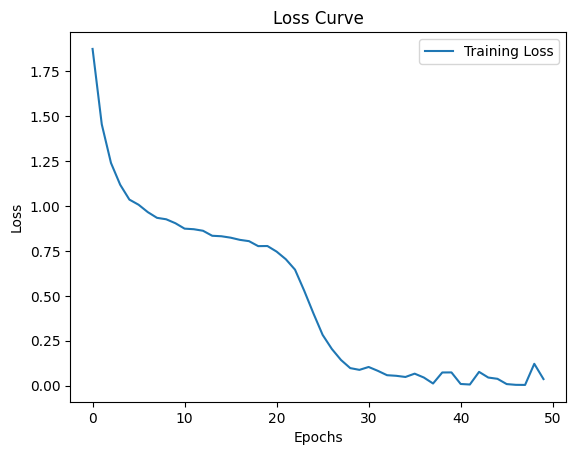

In [22]:
(x_train,x_test,y_train,y_test)= train_test_split(X_text_onehot,y_text_onehot,test_size=0.5)
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

text2text_model1 = train_text_2_text_model(x_train,x_test,y_train,y_test,32,50,15)

In [23]:
loss, accuracy = text2text_model1.evaluate(x_test,y_test)
y_pre = text2text_model1(x_test)
error_analysis(x_test,y_pre)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9977 - loss: 0.0093
Number of misclassification: 76, error_ratio:0.76%
Character-level accuracy: 99.74%
Addition (+) Error Rate: 0.54% (27/4974)
Subtraction (-) Error Rate: 0.97% (49/5026)
Borrowing (->) Error Rate: 0.70% (23/3276)
Carrying (<-) Error Rate: 0.11% (4/3486)
Borrow_Carry_Error/Total_Error: 35.53 % (27/76)
Sample #118
Query: 18+1 
Predicted: 29 
True: 19 
Sample #148
Query: 31+8 
Predicted: 49 
True: 39 
Sample #177
Query: 29-9 
Predicted: 10 
True: 20 
Sample #266
Query: 2-2  
Predicted: 01 
True: 0  
Sample #277
Query: 91+8 
Predicted: 19 
True: 99 
Sample #298
Query: 47-8 
Predicted: 49 
True: 39 
Sample #1147
Query: 85-16
Predicted: 79 
True: 69 
Sample #1210
Query: 99-35
Predicted: 74 
True: 64 
Sample #2174
Query: 9+0  
Predicted: 8  
True: 9  
Sample #2182
Query: 98-9 
Predicted: 99 
True: 89 


# Image-Text

(10000, 5, 28, 28, 1) (10000, 5, 28, 28, 1) (10000, 3, 13) (10000, 3, 13)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_28             │ (None, 5, 28, 28, 16)  │           416 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_29             │ (None, 5, 14, 14, 16)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_30             │ (None, 5, 14, 14, 32)  │         2,080 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_31             │ (None, 5, 7, 7, 32)    │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_32             │ (None, 5, 7, 7, 64)    │         8,256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_33             │ (None, 5, 3, 3, 64)    │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_34             │ (None, 5, 3, 3, 128)   │        32,896 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_35             │ (None, 5, 1152)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_36             │ (None, 5, 64)          │        73,792 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 5, 256)         │       328,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 256)            │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_7 (RepeatVector)  │ (None, 3, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 3, 256)         │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_37             │ (None, 3, 13)          │         3,341 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,500,109 (5.72 MB)

 Trainable params: 1,500,109 (5.72 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - accuracy: 0.3102 - loss: 2.1296 - val_accuracy: 0.3931 - val_loss: 1.8379
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.4006 - loss: 1.7763 - val_accuracy: 0.4290 - val_loss: 1.6055
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.4399 - loss: 1.5658 - val_accuracy: 0.4696 - val_loss: 1.4637
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.4674 - loss: 1.4597 - val_accuracy: 0.4809 - val_loss: 1.4263
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.4974 - loss: 1.3656 - val_accuracy: 0.5078 - val_loss: 1.3374
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.5328 - loss: 1.2724 - val_accuracy: 0.5427 - val_loss: 1.2332
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.5770 - loss: 1.1564 - val_accuracy: 0.5892 - val_loss: 1.1179
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.6394 - loss: 0.9615 - val_acc

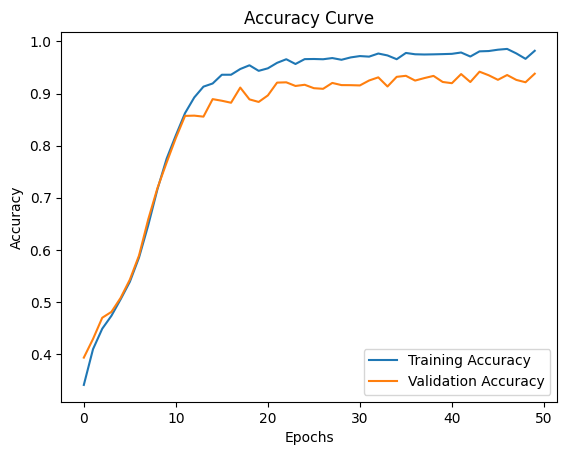

In [24]:
X_img = X_img.reshape((-1, 5, 28, 28, 1))
(x_img_train,x_img_test,y_text_train,y_text_test)= train_test_split(X_img,y_text_onehot,test_size=0.5)
print(x_img_train.shape,x_img_test.shape,y_text_train.shape,y_text_test.shape)

# Build the model
image2text_model = build_img2text_model(add_more_LSTM=True)

# Train the model
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20,restore_best_weights=True)
history = image2text_model.fit(
    x_img_train,
    y_text_train,
    batch_size=16,
    epochs=50,
    validation_data=(x_img_test,y_text_test),
    callbacks=[early_stopping_cb]
)

# Plot training/test accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()


In [25]:
loss, accuracy = image2text_model.evaluate(x_img_test,y_text_test)

# Predict on a sample
sample_idx = 1  # Choose a sample
pre= image2text_model.predict(x_img_test[sample_idx:sample_idx+1])
predicted_text = decode_labels(pre[0])
true_text = decode_labels(y_text_test[sample_idx])
print(f"Predicted: {predicted_text}, True: {true_text}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9410 - loss: 0.2835
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step
Predicted: -9 , True: -9 


# Image-Image

In [26]:
from tensorflow import keras
from functools import partial

# Model parameters
text_dim = 13  # Number of unique characters in queries (13)
max_query_len = max_query_length  # Length of input queries (5)
image_shape = (max_answer_length, 28, 28)  # Shape of output image sequence
lstm_units = 512

dense = partial(keras.layers.Dense,7 * 7 * 64,activation='relu')
reshape = partial(keras.layers.Reshape,(7, 7, 64))
convT1 = partial(keras.layers.Conv2DTranspose,32, (3, 3), activation='relu', strides=(2, 2), padding="same")
convT2 = partial(keras.layers.Conv2DTranspose,1, (3, 3), activation="sigmoid", strides=(2, 2), padding="same")
lstm1 = partial(keras.layers.LSTM,return_sequences=False)
lstm2 = partial(keras.layers.LSTM,return_sequences=True)
repeat_vector = partial(keras.layers.RepeatVector,image_shape[0])
inp = partial(keras.layers.Input,shape=(max_query_len, text_dim))

text_to_image_rnn = keras.models.Sequential([
inp(),
lstm2(lstm_units),
lstm1(lstm_units),
repeat_vector(),
lstm2(lstm_units),
TimeDistributed(dense()),
TimeDistributed(reshape()),
TimeDistributed(convT1()),
TimeDistributed(convT2())
])

# Instantiate and compile the model
text_to_image_rnn.compile(optimizer="adam", loss="mse", metrics=["accuracy"])
text_to_image_rnn.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                  │ (None, 5, 512)         │     1,077,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 512)            │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_8 (RepeatVector)  │ (None, 3, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_20 (LSTM)                  │ (None, 3, 512)         │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_38             │ (None, 3, 3136)        │     1,608,768 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_39             │ (None, 3, 7, 7, 64)    │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_40             │ (None, 3, 14, 14, 32)  │        18,464 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_41             │ (None, 3, 28, 28, 1)   │           289 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,903,169 (26.33 MB)

 Trainable params: 6,903,169 (26.33 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
X_text_onehot = encode_labels(X_text, max_len=max_query_length)

def decay_rate(epoch,lr):
  decay = 1e-1
  return lr/(1+decay*epoch)

early_stopping=keras.callbacks.EarlyStopping(monitor='val_loss',patience=10,mode='min',restore_best_weights=True)
decay_lr=keras.callbacks.LearningRateScheduler(decay_rate)

history = text_to_image_rnn.fit(
    X_text_onehot, y_img,
    validation_split=0.1,
    epochs=30,
    batch_size=16
)

Epoch 1/30
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.8637 - loss: 0.0719 - val_accuracy: 0.8585 - val_loss: 0.0547
Epoch 2/30
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8664 - loss: 0.0542 - val_accuracy: 0.8587 - val_loss: 0.0549
Epoch 3/30
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8665 - loss: 0.0542 - val_accuracy: 0.8587 - val_loss: 0.0547
Epoch 4/30
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8663 - loss: 0.0543 - val_accuracy: 0.8586 - val_loss: 0.0517
Epoch 5/30
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8668 - loss: 0.0488 - val_accuracy: 0.8556 - val_loss: 0.0508
Epoch 6/30
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8653 - loss: 0.0472 - val_accuracy: 0.8546 - val_loss: 0.0508
Epoch 7/30
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8636 - loss: 0.0469 - val_accuracy: 0.8534 - val_loss: 0.0505
Epoch 8/30
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8639 - loss: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


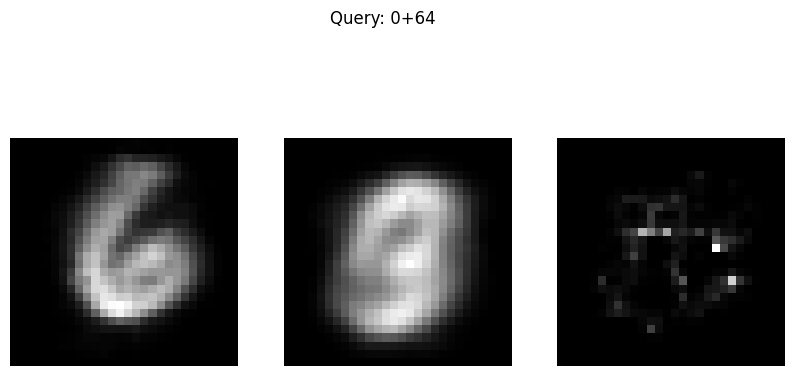

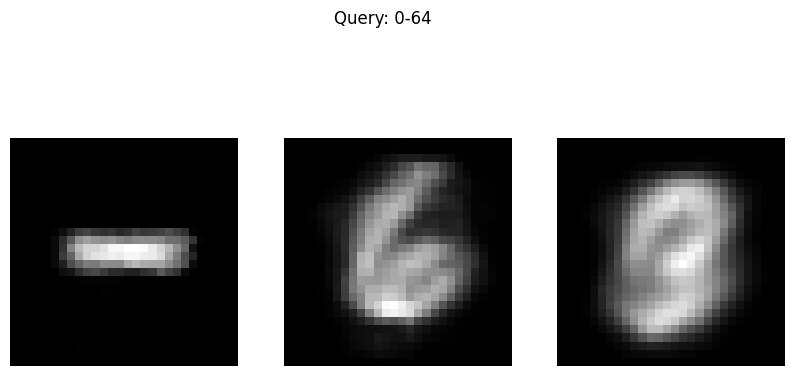

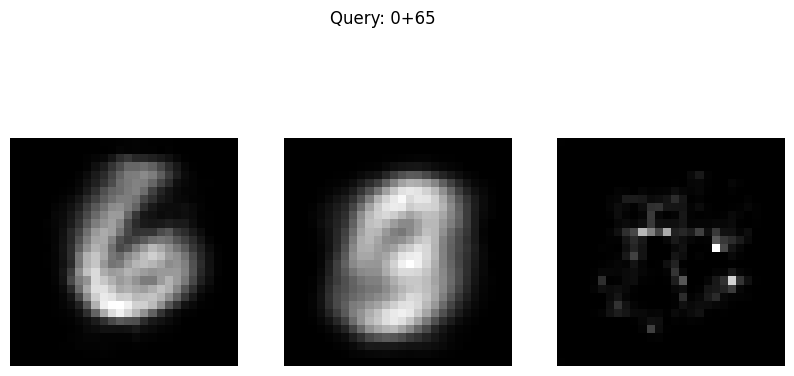

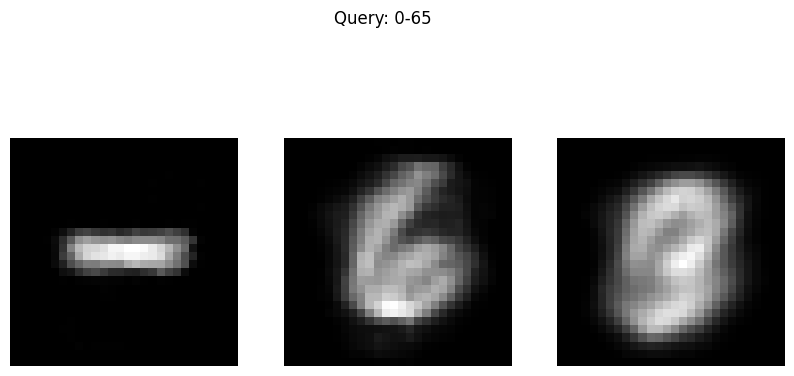

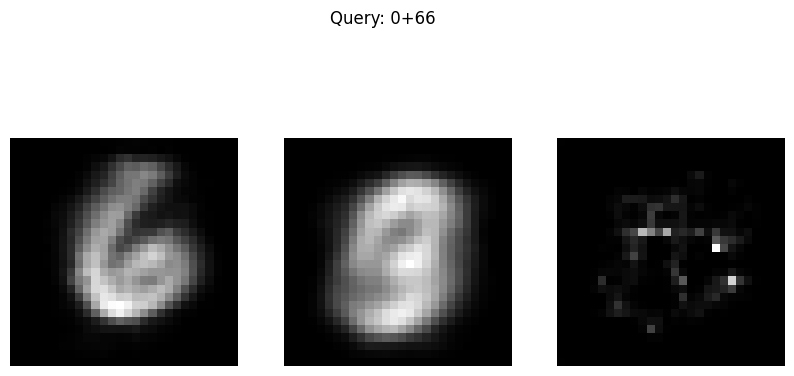

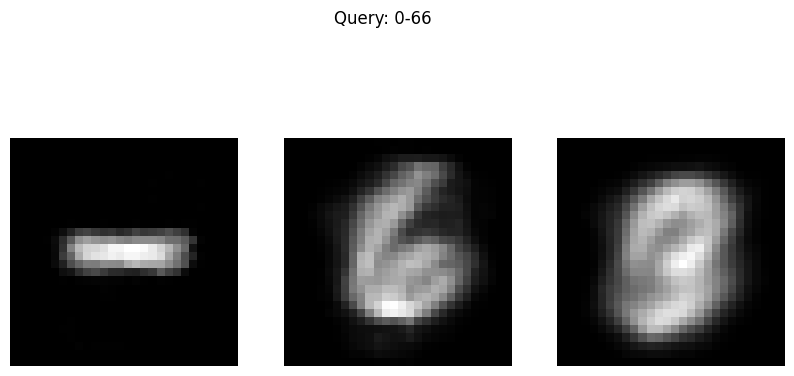

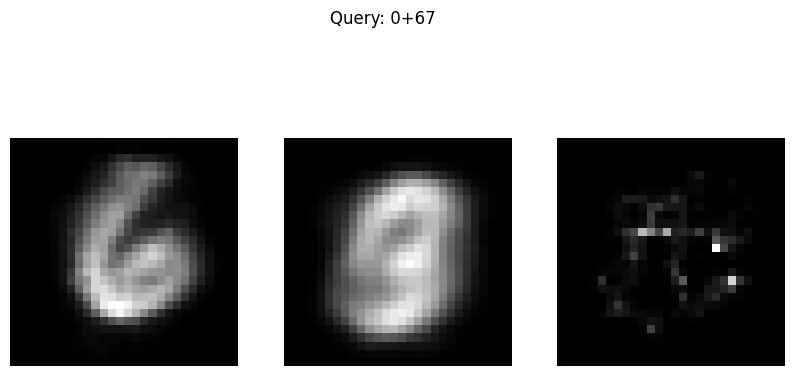

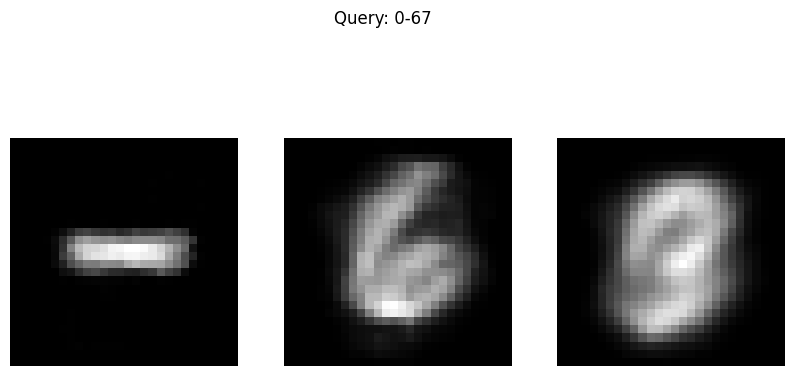

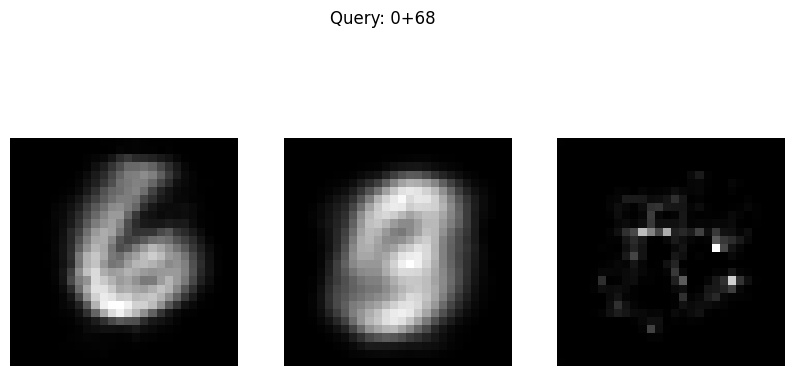

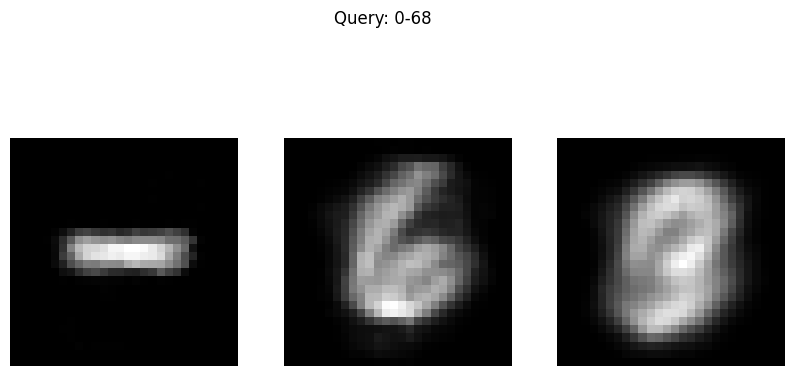

In [28]:
pred_img = text_to_image_rnn.predict(X_text_onehot[128:138])

for i in range(10):
    plt.figure(figsize=(10, 5))
    plt.suptitle(f"Query: {X_text[128+i]}")
    for t in range(max_answer_length):
        plt.subplot(1, max_answer_length, t + 1)
        plt.axis('off')
        plt.imshow(pred_img[i][t], cmap="gray")
    plt.show()